In [1]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract,contract_path
from tqdm.auto import tqdm
import dacite
import torch
from functools import partial
def _toN(t):
    return t.detach().cpu().tolist()
def _toT(t):
    return torch.as_tensor(t)
torch.set_default_tensor_type(torch.DoubleTensor)

In [4]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
importlib.reload(fix_gauge)
from HOTRGZ2 import HOTRG_layers,forward_observable_tensor,forward_two_observable_tensors,trace_tensor,trace_two_tensors
from TNModels import Ising2D,AKLT2D
from GILT import evolve_TRG_GILT_2D,GILT_HOTRG_layer,GILT_options
from fix_gauge import fix_gauges
#from utils import *
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions

# Magnetization Curve

In [5]:
Ising2D.get_default_params()

{'beta': 0.44068679350977147, 'h': 0}

In [41]:
data=pd.DataFrame()
options={
    'nLayers':40,
    'max_dim':12,
    'gilt_enabled':True,
    'gilt_eps':5e-8,
    'gilt_nIter':2
}
gilt_options=GILT_options(**{k[5:]:v for k,v in options.items() if k[:5]=='gilt_'})

for beta in tqdm(np.linspace(-.00005,.00005,9)+0.44068679350977147,leave=False):
    params={'beta':beta}
    model=Ising2D(params)
    
    #dimR=model.get_dimR()
    dimR=None
    layers,Ts,logTotals=HOTRG_layers(model.get_T0(),dimR=dimR,
                            max_dim=options['max_dim'],nLayers=options['nLayers'],
                            HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                            return_tensors=True)
    Ts,T_ops,logTotals=forward_observable_tensor(model.get_T0(),model.get_SZT0(),
                                    layers=layers,checkerboard=model.observable_checkerboard,
                                    return_layers=True,
                                    cached_Ts=Ts)
    for layer in range(len(Ts)):
        T,T_op,logTotal=Ts[layer],T_ops[layer],logTotals[layer]
        logZ=_toN((torch.log(trace_tensor(T))+logTotal)/2**layer)
        magnetization1=_toN(torch.abs(trace_tensor(T_op)/trace_tensor(T)))
        magnetization=_toN((trace_two_tensors(T_op)/trace_two_tensors(T))**.5)
        newRow={**params,
                **options,
                'layer':layer,
                'logZ':logZ,'magnetization':magnetization,'magnetization1':magnetization1}
        data=data.append(newRow,ignore_index=True)
#display(data)



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

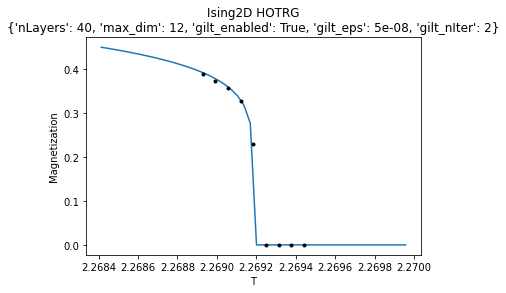

/home/wenhan/jupyter/SRG/IsingSolutions.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I,abserr=scipy.integrate.quad(integrant,0,pi,epsabs=0,epsrel=1e-12)


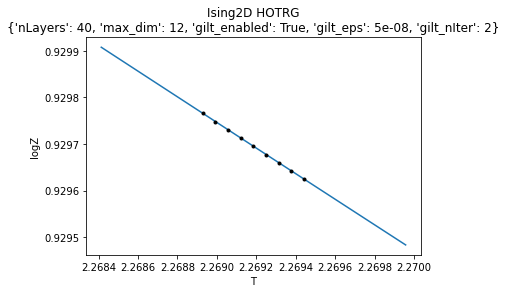

In [42]:

import IsingSolutions
importlib.reload(IsingSolutions)
from IsingSolutions import Ising2DExactSolution,Ising3DMonteCarlo

solution=Ising2DExactSolution()
nLayers=int(max(data['layer']))

def relerr(x,ref):
    return abs(x-ref)/abs(ref)

def abserr(x,ref):
    return abs(x-ref)

ls=np.linspace(min(data['beta'])-.0001,max(data['beta'])+.0001)


plt.plot(1/ls,solution.magnetization(ls))
data1=data[(data['layer']==nLayers)]
plt.plot(1/data1['beta'],data1['magnetization'],'.',color='black')
#plt.plot(1/data1['beta'],data1['magnetization1'],'x')
plt.xlabel('T')
plt.ylabel('Magnetization')
plt.title(f'{type(model).__name__} HOTRG\n{options}')
plt.show()

plt.plot(1/ls,solution.logZ(ls))
data1=data[(data['layer']==nLayers)]
plt.plot(1/data1['beta'],data1['logZ'],'.',color='black')
plt.xlabel('T')
plt.ylabel('logZ')
plt.title(f'{type(model).__name__} HOTRG\n{options}')
plt.show()
    


# TRG Evolution

In [44]:
data=pd.DataFrame()
options={
    'nLayers':30,
    'max_dim':24,
    'gilt_enabled':True,
    'gilt_eps':5e-8,
    'gilt_nIter':2,
}
gilt_options=GILT_options(**{k[5:]:v for k,v in options.items() if k[:5]=='gilt_'})

#params=AKLT2D.get_default_params()
#params['a2']=2.86538
#model=AKLT2D(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(2),model.get_ST0(2)

#params=AKLT2DStrange.get_default_params()
#model=AKLT2DStrange(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(0)+model.get_ST0(1),model.get_ST0(0)-model.get_ST0(1)

params=Ising2D.get_default_params()
params['beta']+=0
model=Ising2D(params)
T0,T0_op1,T0_op2=model.get_T0(),model.get_SZT0(),model.get_SZT0()


reference_scaling_dimensions=[0.125,1,1.125,2]
reference_center_charge=.5

#dimR=model.get_dimR()
dimR=None

layers,Ts,logTotals=HOTRG_layers(T0,dimR=dimR,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                        return_tensors=True)
#Ts_new,T_ops,logTotals=forward_observable_tensor(T0,T0_op1,
#                        layers=layers,checkerboard=model.observable_checkerboard,
#                        return_layers=True,
#                        cached_Ts=None)

#print(trace_two_tensors(T_ops[-1]))
    

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

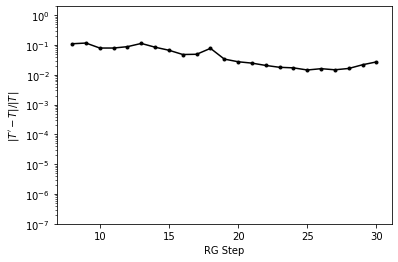

  0%|          | 0/31 [00:00<?, ?it/s]

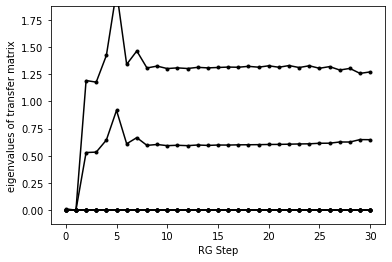

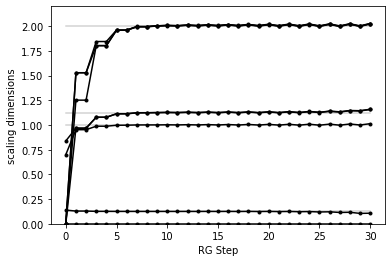

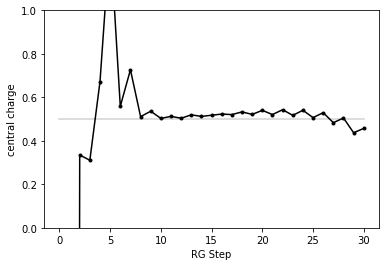

In [45]:

#print(max((a-b).norm() for a,b in zip(Ts,Ts_new)))
show_diff(fix_gauges(Ts,is_HOTRG=True),stride=2)
#show_effective_rank(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)

# correlators

In [48]:
data=pd.DataFrame()
for i in tqdm(list(range(100))):
    th=np.random.uniform(0,np.pi/2)
    r=np.exp(np.random.uniform(np.log(1),np.log(100000)))
    x,y=int(np.abs(r*np.cos(th))),int(np.abs(r*np.sin(th)))
    y=1 if x==0 and y==0 else y
    coords=[x,y]
    if all(c==0 for c in coords):
        continue
    T,T_op12,logTotal=forward_two_observable_tensors(T0,T0_op1,T0_op2,coords=coords,\
                               layers=layers,checkerboard=model.observable_checkerboard,\
                               cached_Ts=Ts)
    correlation=_toN(trace_tensor(T_op12)/trace_tensor(T))
    newRow={**params,
        **options,
        'x':x,'y':y,
        'correlation':correlation,}
    
    data=data.append(newRow,ignore_index=True)
#data

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'shape'

In [47]:
data['dist']=(data['x']**2+data['y']**2)**.5
data['theta']=np.arctan2(data['x'],data['y'])
#p(x) = p[0] * x**deg + ... + p[deg]
#y=exp(p1) x**p0
threshold1=10
data1=data[(data['dist']<threshold1)]
p0,p1=np.polyfit(np.log(data1['dist']),np.log(np.abs(data1['correlation'])),deg=1)



#data1=data[(300<data['dist']) & (data['dist']<1000)]
#q0,q1=np.polyfit(np.log(data1['dist']),np.log(np.abs(data1['correlation'])),deg=1)

data1=data
plt.scatter(data1['dist'],np.abs(data1['correlation']),c=data1['theta'])
plt.plot(data1['dist'],data1['dist']**p0*np.exp(p1),'-',label=f'{np.exp(p1):.2f} x^{p0:.5f}')
#plt.plot(data1['dist'],data1['dist']**q0*np.exp(q1),'-',label=f'{np.exp(q1):.2f} x^{q0:.5f}')
plt.axvline(threshold1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-3,3])
plt.title(f'{type(model).__name__} HOTRG GILT\n{params}\n{options}')
plt.legend()
plt.show()

TypeError: expected non-empty vector for x

# diagonal TRG method

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

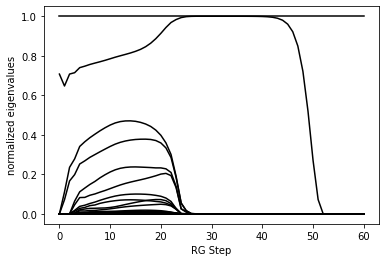

  0%|          | 0/61 [00:00<?, ?it/s]

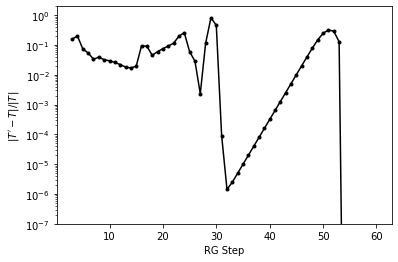

  0%|          | 0/61 [00:00<?, ?it/s]

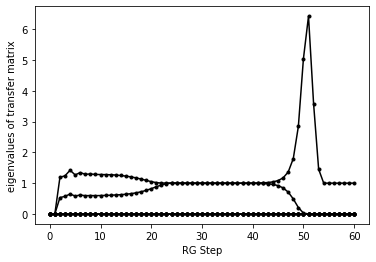

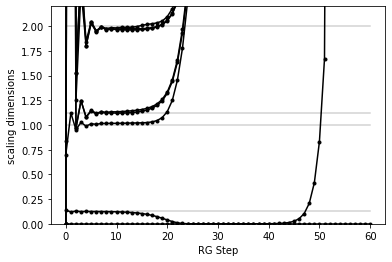

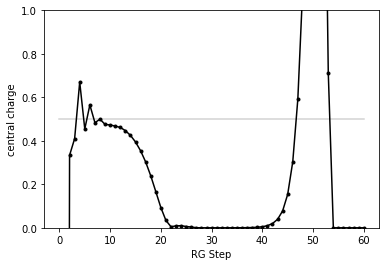

In [245]:
options={
    'nLayers':60,
    'max_dim':12,
    'gilt_enabled':True,
    'gilt_eps':5e-8,
    'gilt_nIter':2,
}
gilt_options=GILT_options(**{k[5:]:v for k,v in options.items() if k[:5]=='gilt_'})


#critical beta: 0.44068679350977147
params={'beta':.4409}
#params={'beta':0.44068679350977147}#critical
model=Ising2D(params)



Ts,logNorms=evolve_TRG_GILT_2D(model.get_T0(),
                               nLayers=options['nLayers'],max_dim=options['max_dim'],
                               options=gilt_options,
                               return_layers=True)
show_effective_rank(Ts)
show_diff(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,reference_scaling_dimensions=[0.125,1,1.125,2],reference_center_charge=.5)
# two_pass seems give higher cT: one_pass=.440606 two_pass=.440618 ref=.440686 max_dim=8
# not spliting insertion greatly changes cT: one_pass=.440298 two_pass=.440803 max_dim=8